In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.cm as cm

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  # don’t use 0 for Hub

In [2]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [4]:
index_LHS = 43
subset = np.load("./LHS_incl3.npy")
subset = subset[index_LHS, 30, 0, 10]
subset = subset.reshape(-1, 64, 64)

# agumentation
xprime = np.zeros_like(subset)
for i in range(subset.shape[0]):
    xnew = subset[i]  + 0.1*np.std(subset[i])* np.random.random( (64, 64) )
    xnew = (np.log10(xnew) - np.log10(xnew.max()) + 2.) / 2.
    xprime[i] = xnew 
xprime[xprime < 0] = 0
subset = xprime

In [5]:
model = tf.keras.models.load_model("./model_mse/resnet_allincl_175_20_1000epoch_augonlyshift_twooutputs")
# good, but the image should be large enough... 

In [6]:
Tb_ALMA = np.load("LHS43_45incl_ALMA.npy")

In [7]:
alpha_truth  = np.load("LHS150seed1.npy").T[0, index_LHS]
alpha_woCASA = 10**(model.predict(subset[:, :, :, None])[0,1] * (2) + -4) 
alpha_wCASA  = 10**(model.predict(Tb_ALMA[None, :, :, None])[0,1] * (2) + -4) 

In [9]:
print (f"true alpha: {alpha_truth:1.1e}")
print (f"predicted alpha wo CASA: {alpha_woCASA:1.1e}")
print (f"predicted alpha w CASA: {alpha_wCASA:1.1e}")

true alpha: 1.4e-03
predicted alpha wo CASA: 1.2e-03
predicted alpha w CASA: 1.3e-03


In [11]:
Mpmin = np.log10(0.000033)
Mpmax = np.log10(0.000033 * np.sqrt(10)**(4))

In [13]:
Mp_truth = np.load("LHS150seed1.npy").T[2, index_LHS]
Mp_woCASA = 10**(model.predict(subset[:, :, :, None])[0,0] * (Mpmax - Mpmin) + Mpmin)
Mp_wCASA = 10**(model.predict(Tb_ALMA[None, :, :, None])[0,0] * (Mpmax - Mpmin) + Mpmin) 

In [15]:
print (f"true Mp: {Mp_truth:1.1e}")
print (f"predicted wo CASA: {Mp_woCASA:1.1e}")
print (f"predicted w CASA: {Mp_wCASA:1.1e}")

true Mp: 2.2e-03
predicted wo CASA: 2.3e-03
predicted w CASA: 1.8e-03


In [79]:
mj = 0.000954265748

In [81]:
print (f"true Mp: {Mp_truth/mj:1.2e}")
print (f"predicted wo CASA: {Mp_woCASA/mj:1.2e}")
print (f"predicted w CASA: {Mp_wCASA/mj:1.2e}")

true Mp: 2.28e+00
predicted wo CASA: 2.39e+00
predicted w CASA: 1.92e+00


/home/shjzhang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: The following kwargs were not used by contour: 'rasterized'


<Figure size 540x216 with 0 Axes>

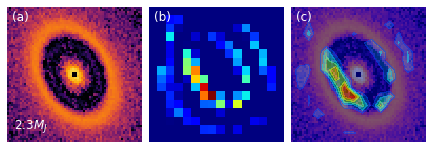

In [17]:
layerlist = [layer.name for layer in model.layers]
last_conv_layer_i=64
plt.rc("font", size=12)
plt.figure(figsize = (7.5, 3))
last_conv_layer_name = layerlist[last_conv_layer_i]
classifier_layer_names = layerlist[last_conv_layer_i+1:]

img_array = subset[:, :, :, None]
heatmap = make_gradcam_heatmap(
            img_array, model, last_conv_layer_name, classifier_layer_names)

plt.rc("font", size=12)
plt.figure(figsize = (7.5, 3))
plt.subplot(131)

plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno', vmax=1.1)
plt.text(0.1, 0.9, "(a)", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.text(0.05, 0.1, r"2.3$M_J$", transform=plt.gca().transAxes, color='w', horizontalalignment='left',
        fontsize=12)
plt.axis('off')
plt.subplot(132)
plt.imshow(heatmap, cmap='jet', origin="lower")
plt.text(0.1, 0.9, "(b)", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.axis('off')

plt.subplot(133)
plt.contourf(heatmap, alpha=0.5, cmap='jet', rasterized=True)
plt.text(0.1, 0.9, "(c)", transform=plt.gca().transAxes, color='w', horizontalalignment='center')

plt.imshow(img_array[0,:,:,0], extent=(0, 15,0, 15), origin='lower', cmap='inferno')
plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)
#plt.savefig("gradcam_v2.pdf", bbox_inches='tight', transparent=True)

/home/shjzhang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: The following kwargs were not used by contour: 'rasterized'


<Figure size 540x216 with 0 Axes>

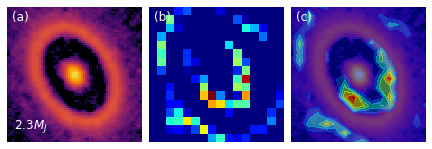

In [18]:
i=64
plt.rc("font", size=12)
plt.figure(figsize = (7.5, 3))
last_conv_layer_name = layerlist[i]
classifier_layer_names = layerlist[i+1:]

img_array = Tb_ALMA[None, :, :, None]
heatmap = make_gradcam_heatmap(
            img_array, model, last_conv_layer_name, classifier_layer_names)



plt.rc("font", size=12)
plt.figure(figsize = (7.5, 3))
plt.subplot(131)

plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno', vmax=1.1)
plt.text(0.1, 0.9, "(a)", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.text(0.05, 0.1, r"2.3$M_J$", transform=plt.gca().transAxes, color='w', horizontalalignment='left',
        fontsize=12)
plt.axis('off')
plt.subplot(132)
plt.imshow(heatmap, cmap='jet', origin="lower")
plt.text(0.1, 0.9, "(b)", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.axis('off')

plt.subplot(133)
plt.contourf(heatmap, alpha=0.5, cmap='jet', rasterized=True)
plt.text(0.1, 0.9, "(c)", transform=plt.gca().transAxes, color='w', horizontalalignment='center')

plt.imshow(img_array[0,:,:,0], extent=(0, 15,0, 15), origin='lower', cmap='inferno')
plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)
#plt.savefig("gradcam_v2.pdf", bbox_inches='tight', transparent=True)

/home/shjzhang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: The following kwargs were not used by contour: 'rasterized'


<Figure size 540x216 with 0 Axes>

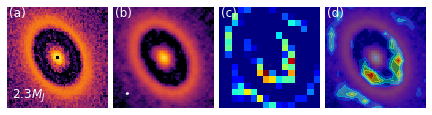

In [78]:
i=64

from astropy.io import fits
from matplotlib.patches import Ellipse
header = fits.getheader("./LHS43_incl45.image.fits")
majratio = header['BMAJ'] * 3600 / (6.*40/140) # 6rp
minratio = header['BMIN'] * 3600 / (6.*40/140) # 6rp

plt.rc("font", size=12)
plt.figure(figsize = (7.5, 3))
last_conv_layer_name = layerlist[i]
classifier_layer_names = layerlist[i+1:]

plt.rc("font", size=12)
plt.figure(figsize = (7.5, 3))

img_array = subset[:, :, :, None]
heatmap = make_gradcam_heatmap(
            img_array, model, last_conv_layer_name, classifier_layer_names)

plt.subplot(141)
plt.imshow(img_array[0,:,:,0], extent=(0, 31,0, 31), origin='lower', cmap='inferno', vmax=1.1)
plt.text(0.1, 0.9, "(a)", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.text(0.05, 0.1, r"2.3$M_J$", transform=plt.gca().transAxes, color='w', horizontalalignment='left',
        fontsize=12)
plt.axis('off')


plt.subplot(142)
img_array = Tb_ALMA[None, :, :, None]
heatmap = make_gradcam_heatmap(
            img_array, model, last_conv_layer_name, classifier_layer_names)
plt.imshow(img_array[0,:,:,0], origin='lower', cmap='inferno', vmax=1.1,
          extent=(0, 1/np.sqrt(2), 0, 1/np.sqrt(2)))
plt.text(0.1, 0.9, "(b)", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
#plt.text(0.05, 0.1, , transform=plt.gca().transAxes, color='w', horizontalalignment='left',
#        fontsize=12)
plt.axis('off')
e = Ellipse(xy=(0.1, 0.1),
                width=majratio, height=minratio,
                angle=header['BPA'], facecolor='w')
ax=plt.gca()
ax.add_artist(e)

plt.subplot(143)
plt.imshow(heatmap, cmap='jet', origin="lower")
plt.text(0.1, 0.9, "(c)", transform=plt.gca().transAxes, color='w', horizontalalignment='center')
plt.axis('off')

plt.subplot(144)
plt.contourf(heatmap, alpha=0.5, cmap='jet', rasterized=True)
plt.text(0.1, 0.9, "(d)", transform=plt.gca().transAxes, color='w', horizontalalignment='center')

plt.imshow(img_array[0,:,:,0], extent=(0, 15,0, 15), origin='lower', cmap='inferno')
plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)
#plt.savefig("gradcam_v3.pdf", bbox_inches='tight', transparent=True)